In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import seaborn as sns
from tabulate import tabulate

In [2]:
def fetch_stock_data(ticker: str, start: str, end: str = None):
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    return data

def compute_parameters(data: pd.DataFrame):
    log_returns = np.log(1+data['Close'].pct_change())
    mu = log_returns.mean()
    var = log_returns.var()
    drift = mu - (0.5*var)
    stdev = log_returns.std()
    return log_returns, drift, stdev

def detect_jumps(log_returns: pd.Series, sigma_cutoff: float = 3):
    log_returns = log_returns.squeeze()
    mu = log_returns.mean()
    sigma = log_returns.std()
    threshold = sigma_cutoff * sigma
    jump_mask = (np.abs(log_returns - mu) > threshold)
    jump_returns = log_returns[jump_mask]
    total_days = len(log_returns)
    total_jumps = int(jump_mask.sum())
    years = total_days / 252
    lambda_ = total_jumps / years if years > 0 else 0
    mu_j = jump_returns.mean() if total_jumps > 0 else 0
    sigma_j = jump_returns.std() if total_jumps > 0 else 0
    jump_df = pd.DataFrame({
        "Date": log_returns.index,
        "LogAdjReturn": log_returns.values,
        "Jump": jump_mask.astype(int)
    })
    return total_days,total_jumps,jump_df, lambda_, mu_j, sigma_j
    
def simulate_price_paths(data, drift, stdev, days, trials, lambda_, mu_j, sigma_j):
    Z = norm.ppf(np.random.rand(days, trials))
    dt= 1/252
    N = np.random.poisson(lambda_ * dt, size=(days, trials))  # 0 or 1 most of the time
    J = np.random.normal(mu_j, sigma_j, size=(days, trials))  # jump magnitude
    jumps = N * J
    daily_returns = np.exp(np.array(drift) + np.array(stdev) * Z + np.array(jumps))
    
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = data['Close'].iloc[-1]
    
    for t in range (1,days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]
    
    return price_paths

def plot_price_paths(price_paths: np.ndarray):
    df = pd.DataFrame(price_paths)
    plt.figure(figsize=(12, 6))
    plt.plot(df)
    
    # Auto adjustment Axis for better visuals
    plt.xlim(0, df.shape[0] - 1)
    plt.ylim(df.min().min() * 0.95, df.max().max() * 1.05)

    plt.title("Simulated Price Paths")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_VaR_CVaR(price_paths: np.ndarray, confidence_level):
    ending_prices = price_paths[-1, :]
    VaR_price = np.percentile(ending_prices, (1 - confidence_level) * 100)
    shortfall = ending_prices[ending_prices <= VaR_price]
    CVaR = np.mean(shortfall)
    return ending_prices,VaR_price,CVaR
    
def plot_var(ending_prices,VaR_price,confidence_level):
    plt.figure(figsize=(10, 5))
    sns.histplot(ending_prices, kde=True, color="skyblue", bins=50)
    plt.axvline(VaR_price, color='red', linestyle='--',
                label=f"{int(confidence_level*100)}% VaR = ${VaR_price:.2f}")
    plt.title("Distribution of Final Simulated Prices")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 
def summary_data(ticker,start,end,S0,price_paths,confidence_level,VaR_price,CVaR,lambda_,mu_j,sigma_j,total_days,total_jumps):
    summary_data = {
        "Ticker": ticker,
        "Start_Date": start,
        "End_Date": end if end else "latest",
        "Initial_Price": round(S0, 2),
        "Days_Simulated": price_paths.shape[0],
        "Trials": price_paths.shape[1],
        f"VaR_{int(confidence_level * 100)}%": round(VaR_price, 2),
        "CVaR": round(CVaR, 2),
        "Lambda_JumpsPerYear": round(lambda_, 3),
        "Mu_JumpMean": round(mu_j, 5),
        "Sigma_JumpStd": round(sigma_j, 5),
        "Total_Days_Observed": total_days,
        "Total_Jumps_Observed": total_jumps
    }
    summary_df = pd.DataFrame([summary_data])
    return(summary_df)

In [3]:
# Main runner:

In [4]:
# Step 1: Input and Fetch stock data
ticker = input("Enter stock ticker (e.g., AAPL): ").strip().upper()
start = input("Enter start date (YYYY-MM-DD): ").strip()
end = input("Enter end date (YYYY-MM-DD or leave blank for today's date): ").strip() or None

print("\n🗓️ How many future days do you want to simulate?")
print("Typical values: 1 for daily VaR, 5 for weekly, 10–30 for longer-term risk")
days = int(input("Enter number of simulation days: "))

print("\n🔁 How many simulation trials should we run?")
print("Typical values: 1000 for quick test, 10,000 for good accuracy, 50,000+ for production")
trials = int(input("Enter number of trials (simulated paths): "))

print(f"\n📈 Running simulation for {ticker} from {start} to {end or 'latest'}...")
data = fetch_stock_data(ticker, start, end)

Enter stock ticker (e.g., AAPL):  GFS
Enter start date (YYYY-MM-DD):  2020-01-01
Enter end date (YYYY-MM-DD or leave blank for today's date):  



🗓️ How many future days do you want to simulate?
Typical values: 1 for daily VaR, 5 for weekly, 10–30 for longer-term risk


Enter number of simulation days:  5



🔁 How many simulation trials should we run?
Typical values: 1000 for quick test, 10,000 for good accuracy, 50,000+ for production


Enter number of trials (simulated paths):  10000



📈 Running simulation for GFS from 2020-01-01 to latest...


[*********************100%***********************]  1 of 1 completed


In [5]:
# Step 2: Compute log returns and model parameters
log_returns, drift, stdev = compute_parameters(data)

In [6]:
# Step 3: Calculate jump parameters or Input your average Jump 
use_auto_jump = input("Do you want to auto-detect jumps? (y/n): ").strip().lower()

if use_auto_jump == "y":
    sigma_cutoff_input = input("Input your sigma cutoff (default = 3): ").strip()
    sigma_cutoff = float(sigma_cutoff_input) if sigma_cutoff_input else 3.0

    total_days, total_jumps, jump_df, lambda_, mu_j, sigma_j = detect_jumps(log_returns, sigma_cutoff)
    print(f"\n✅ Auto-detected {total_jumps} jumps over {total_days} trading days")
    print("📈 Simulating Price Paths using GBM with Jump Diffusion Model")

else:
    # Manual input mode
    avg_jump_input = input("Enter average jumps per year (e.g., 2.0, default = 0): ").strip()
    lambda_ = float(avg_jump_input) if avg_jump_input else 0

    if lambda_ != 0:
        mu_j_input = input("Enter average jump size (mu_j), e.g., -0.02 (default = -0.02): ").strip()
        sigma_j_input = input("Enter jump volatility (sigma_j), e.g., 0.10 (default = 0.10): ").strip()

        mu_j = float(mu_j_input) if mu_j_input else -0.02
        sigma_j = float(sigma_j_input) if sigma_j_input else 0.10
        print("\n✏️  Manual input of jump parameters accepted")
        print("📈 Simulating Price Paths using GBM with Jump Diffusion Model")

    else:
        mu_j = 0
        sigma_j = 0
        print("\n📉 No jumps will be included (lambda = 0)")
        print("📈 Simulating Price Paths using standard GBM")

    jump_df = None
    total_days = len(log_returns)
    total_jumps = int(lambda_ * total_days / 252)

Do you want to auto-detect jumps? (y/n):  y
Input your sigma cutoff (default = 3):  3



✅ Auto-detected 10 jumps over 914 trading days
📈 Simulating Price Paths using GBM with Jump Diffusion Model


In [7]:
# Step 4: Simulate price paths (Jump Diffusion Model)
price_paths = simulate_price_paths(data, drift, stdev, days, trials, lambda_, mu_j, sigma_j)

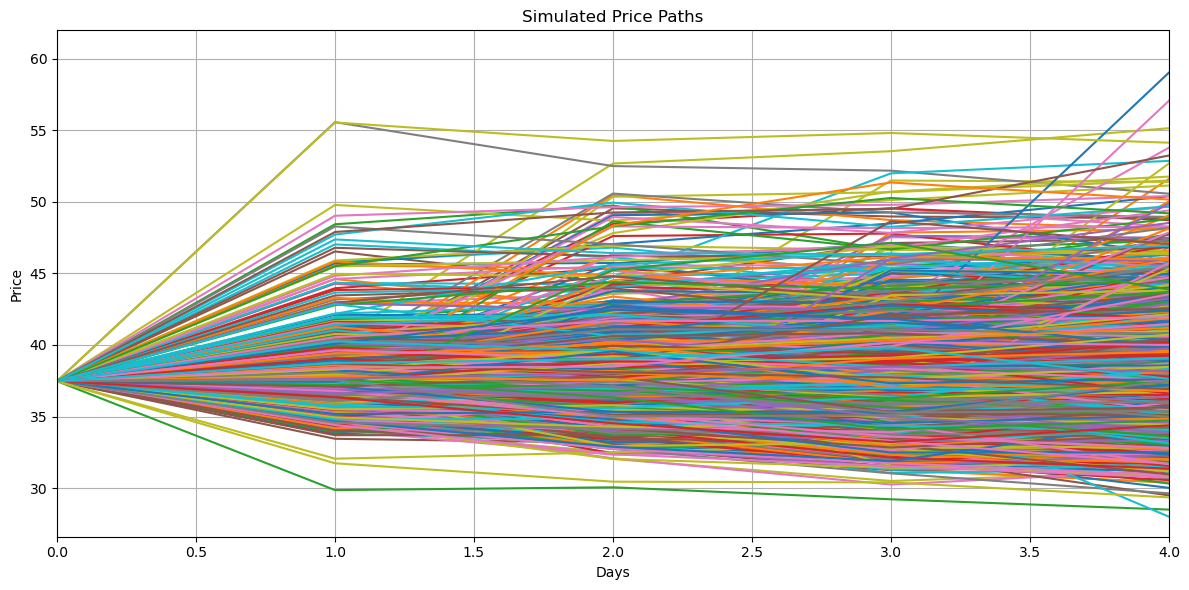

In [8]:
# Step 5: Plot price paths
plot_price_paths(price_paths)

In [9]:
#Step 6: Calculate Expected Value at Risk (VaR) and Shortfall (CVaR)
print("\n🔒 Enter your desired confidence level for VaR calculation.") #default will take CI =0.95
print("   Typical values: 0.90 for 90%, 0.95 for 95%")
confidence_level = float(input("Enter confidence level (e.g., 0.95): ") or 0.95)

ending_prices,VaR_price,CVaR = compute_VaR_CVaR(price_paths, confidence_level)
print()
S0 = price_paths[0, 0]
print(f"📌 Initial Price(S₀) on {end}: ${S0:.2f}")
print(f"📉 {int(confidence_level*100)}% VaR: ${VaR_price:.2f}")
print(f"💥 Expected Shortfall (CVaR): ${CVaR:.2f}")


🔒 Enter your desired confidence level for VaR calculation.
   Typical values: 0.90 for 90%, 0.95 for 95%


Enter confidence level (e.g., 0.95):  0.95



📌 Initial Price(S₀) on None: $37.47
📉 95% VaR: $33.61
💥 Expected Shortfall (CVaR): $32.71


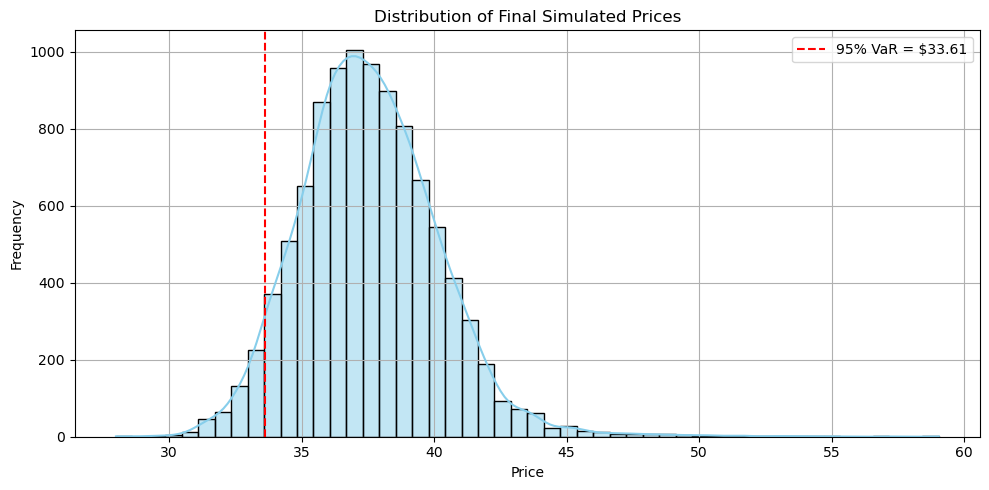

In [10]:
#Step 7: Plot VaR in Histogram
plot_var(ending_prices, VaR_price, confidence_level)

In [11]:
#Step 8: Tabulate the data 
summary_df = summary_data(ticker, start, end, S0, price_paths, confidence_level,
                          VaR_price, CVaR, lambda_, mu_j, sigma_j, total_days, total_jumps)
summary_df_transposed = summary_df.T.reset_index() # Transpose and reset index for export
summary_df_transposed.columns = ['Metric', 'Value']
print("\n📊 Summary Table:")
print(tabulate(summary_df.T, headers=["Metric", "Value"], tablefmt="fancy_grid"))


📊 Summary Table:
╒══════════════════════╤════════════╕
│ Metric               │ Value      │
╞══════════════════════╪════════════╡
│ Ticker               │ GFS        │
├──────────────────────┼────────────┤
│ Start_Date           │ 2020-01-01 │
├──────────────────────┼────────────┤
│ End_Date             │ latest     │
├──────────────────────┼────────────┤
│ Initial_Price        │ 37.47      │
├──────────────────────┼────────────┤
│ Days_Simulated       │ 5          │
├──────────────────────┼────────────┤
│ Trials               │ 10000      │
├──────────────────────┼────────────┤
│ VaR_95%              │ 33.61      │
├──────────────────────┼────────────┤
│ CVaR                 │ 32.71      │
├──────────────────────┼────────────┤
│ Lambda_JumpsPerYear  │ 2.757      │
├──────────────────────┼────────────┤
│ Mu_JumpMean          │ 0.08053    │
├──────────────────────┼────────────┤
│ Sigma_JumpStd        │ 0.09876    │
├──────────────────────┼────────────┤
│ Total_Days_Observed  │ 914    

In [12]:
save_csv = input("Save results to CSV? (y/n): ").strip().lower() == 'y'

if save_csv:
    files_to_save = {
        "jumps": jump_df,
        "price_paths": price_paths,
        "summary": summary_df_transposed
    }

    for name, df in files_to_save.items():
        # Convert to DataFrame if it's a NumPy array
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df)

        filename = f"data/{ticker}_{name}.csv"
        df.to_csv(filename, index=False)
        print(f"📄 {name.replace('_', ' ').title()} data saved to {filename}")
        print()  # extra newline
else:
    pass


Save results to CSV? (y/n):  n
